# **Group 11 - EDA - Big Data and Cloud Computing (ADSP 31013)**

## Members:
- #### **Andrew Rafael James** 
- #### **Aravind Shreyas Ramesh** 
- #### **Reethesh Venkatraman** 
- #### **Rohit Kumar** 
- #### **Sahil Bharwani**

---

### **Flight Delay Prediction:**
*This project aims to identify drivers of delay of departures and arrival flights considering various factors including but not limited to origin, destination, distance, weather, taxi time, time, seasonality etc. and quantify the effect of these drivers.*

# **Data Overview, EDA and Summary Statistics**

### *PySpark Settings*

In [1]:
import time
import json
from numpy import array, mean
import pandas as pd
import requests

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.functions import year, to_date, date_format,hour,minute,expr
from pyspark.sql.functions import from_json, col, udf, schema_of_json, size, explode, collect_set, map_keys
from pyspark.sql.functions import isnan, when, count, col,lower, split, trim, concat_ws,corr
from pyspark.sql.types import BooleanType, MapType, StructType, StructField, StringType

from pyspark.sql.functions import col, radians, sin, cos, atan2, sqrt
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder \
.appName('Group11-Final-Pipeline') \
.config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
.getOrCreate()

# spark.sparkContext.getConf().getAll()
#set log level
spark.sparkContext.setLogLevel("ERROR")

In [3]:
# GCS path to the Parquet file
gcs_path = "gs://msca-bdp-student-gcs/Group11/flight_weather_joined_2018_2021_v2.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(gcs_path)

### ***Features Overview***

In [4]:
df.printSchema()
df.show(5)

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

24/12/02 19:54:05 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+--------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+----------------+-------------------+-----------+-----------+-----------+-----------+-------------------+--

## ***Missing Values Summary***

In [5]:
missing_data = df.select([(count(when(col(c).isNull(), c)) / count("*")).alias(c) for c in df.columns])
missing_data_df = missing_data.toPandas().transpose()
missing_data_df.columns = ["Missing_Percentage"]
missing_data_df.reset_index(inplace=True)
missing_data_df.rename(columns={"index": "Column"}, inplace=True)
print(missing_data_df.sort_values(by="Missing_Percentage", ascending=False))


                             Column  Missing_Percentage
76                        TMIN_dest            0.108457
65                      TMIN_origin            0.108445
75                        TMAX_dest            0.108318
64                      TMAX_origin            0.108306
12                          AirTime            0.028634
..                              ...                 ...
33               OriginCityMarketID            0.000000
32               OriginAirportSeqID            0.000000
31                  OriginAirportID            0.000000
30  Flight_Number_Operating_Airline            0.000000
41                 DestCityMarketID            0.000000

[83 rows x 2 columns]


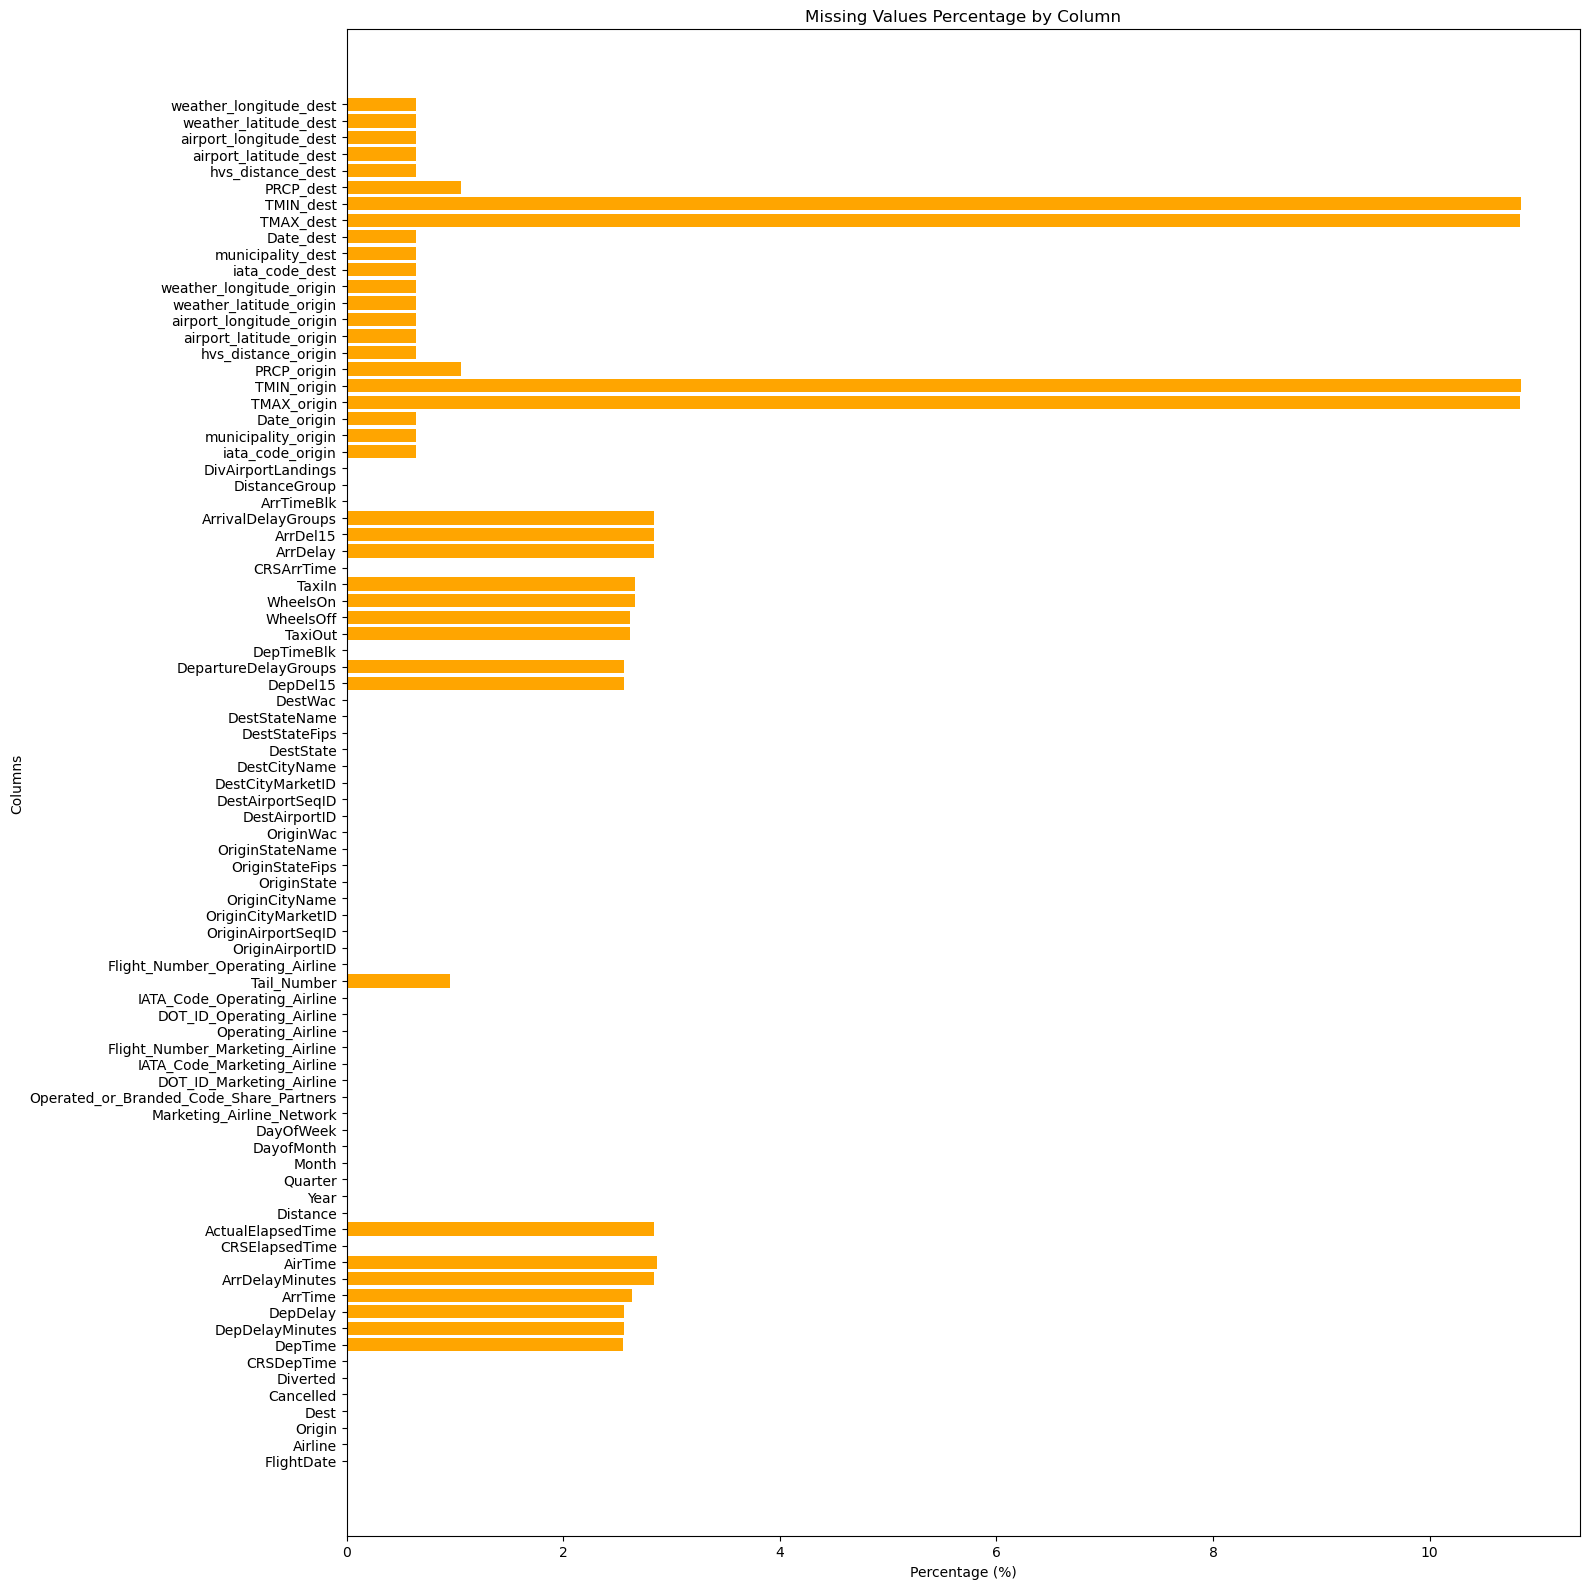

In [6]:
plt.figure(figsize=(16, 16))
plt.barh(missing_data_df["Column"], missing_data_df["Missing_Percentage"] * 100, color='orange')
plt.title("Missing Values Percentage by Column")
plt.xlabel("Percentage (%)")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

### 

In [7]:
from pyspark.sql.functions import col, mean, stddev, min, max, variance

numerical_columns = [
    "DepDelayMinutes", "ArrDelayMinutes", "AirTime", "Distance", 
    "CRSElapsedTime", "ActualElapsedTime", "TaxiOut", "TaxiIn", 
    "DepDel15", "ArrDel15", "ArrDelay", "DepartureDelayGroups", 
    "ArrivalDelayGroups", 'PRCP_dest', 'PRCP_origin', 'Quarter', 'TMAX_dest', 'TMAX_origin', 'TMIN_dest', 'TMIN_origin', "hvs_distance_origin",'hvs_distance_dest'
]

summary_stats = []
for col_name in numerical_columns:
    stats = {
        "Column": col_name,
        "Mean": df.select(mean(col(col_name))).first()[0],
        "StdDev": df.select(stddev(col(col_name))).first()[0],
        "Min": df.select(min(col(col_name))).first()[0],
        "Max": df.select(max(col(col_name))).first()[0],
        "Variance": df.select(variance(col(col_name))).first()[0],
    }

    quantiles = df.approxQuantile(col_name, [0.5], 0.05)
    stats["Median"] = quantiles[0] if quantiles else None
    summary_stats.append(stats)

import pandas as pd
summary_stats_df = pd.DataFrame(summary_stats)

pd.set_option('display.max_columns', None)  # Ensure all columns are visible
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats for better readability
print(summary_stats_df)

                  Column   Mean  StdDev      Min     Max  Variance  Median
0        DepDelayMinutes  12.26   45.08     0.00 3890.00   2032.20    0.00
1        ArrDelayMinutes  12.33   44.70     0.00 3864.00   1998.18    0.00
2                AirTime 108.78   68.92 -1244.00 1557.00   4749.38   89.00
3               Distance 776.79  579.55    16.00 5812.00 335874.81  600.00
4         CRSElapsedTime 138.34   70.60  -292.00 1645.00   4983.92  120.00
5      ActualElapsedTime 132.88   70.59 -1228.00 1604.00   4983.46  114.00
6                TaxiOut  16.67    9.37     0.00 1394.00     87.86   15.00
7                 TaxiIn   7.47    5.99     0.00  316.00     35.92    6.00
8               DepDel15   0.17    0.37     0.00    1.00      0.14    0.00
9               ArrDel15   0.17    0.38     0.00    1.00      0.14    0.00
10              ArrDelay   2.98   48.22 -1290.00 3864.00   2324.72   -8.00
11  DepartureDelayGroups  -0.05    2.13    -2.00   12.00      4.54   -1.00
12    ArrivalDelayGroups 

In [8]:
print("Distribution of DepDel15:")
df.groupBy("DepDel15").count().show()

print("Distribution of ArrDel15:")
df.groupBy("ArrDel15").count().show()

cancelled_count = df.filter(col("Cancelled") == True).count()
total_flights = df.count()
print(f"Percent of Flights Cancelled: {cancelled_count / total_flights * 100:.2f}%")

diverted_count = df.filter(col("Diverted") == True).count()
print(f"Percent of Flights Diverted: {diverted_count / total_flights * 100:.2f}%")

Distribution of DepDel15:


+--------+--------+
|DepDel15|   count|
+--------+--------+
|     0.0|20425615|
|    null|  642589|
|     1.0| 4047260|
+--------+--------+

Distribution of ArrDel15:


+--------+--------+
|ArrDel15|   count|
+--------+--------+
|     0.0|20249872|
|    null|  712781|
|     1.0| 4152811|
+--------+--------+



Percent of Flights Cancelled: 2.60%


Percent of Flights Diverted: 0.23%


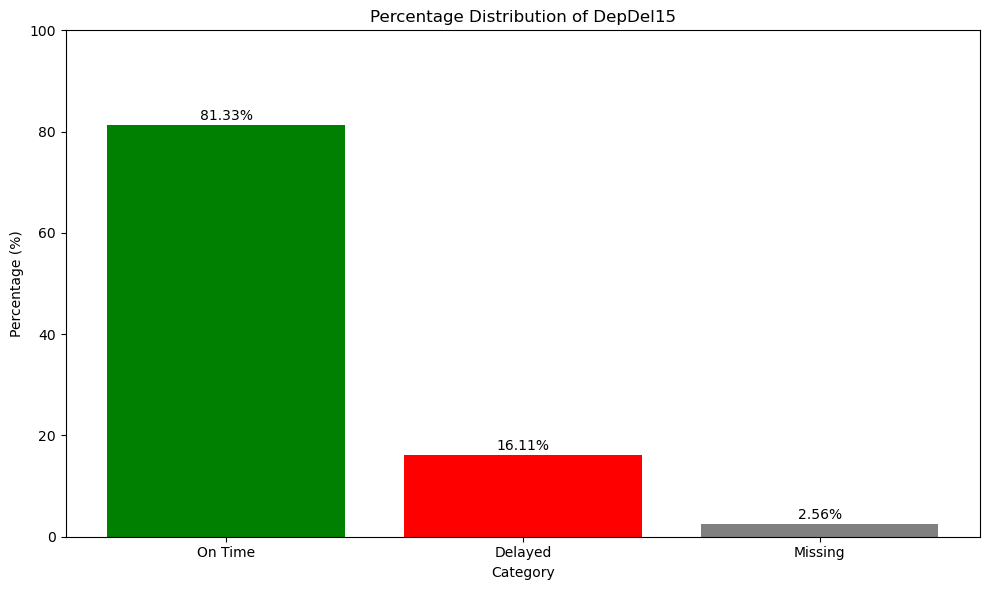

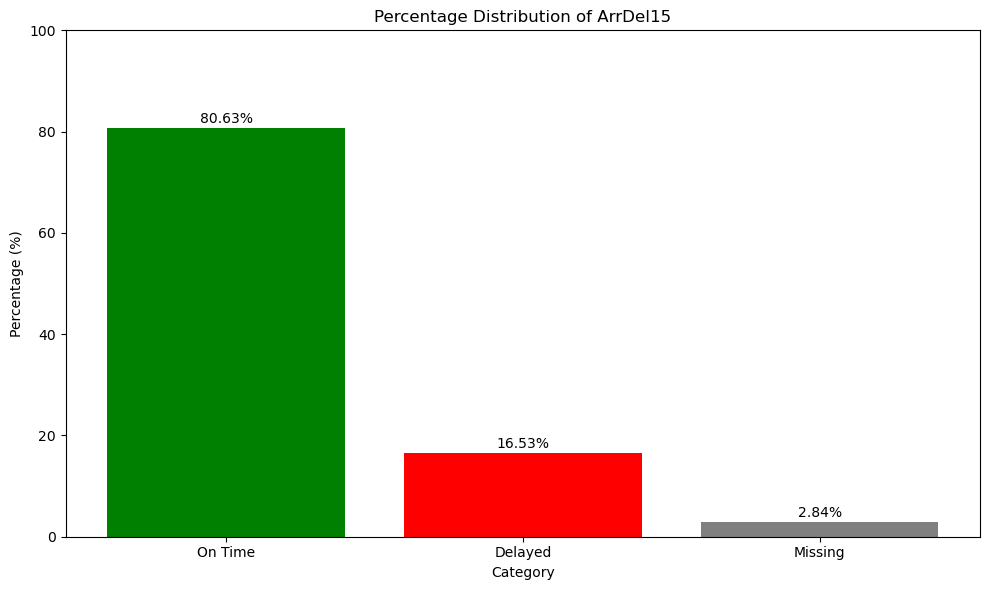

In [9]:
import matplotlib.pyplot as plt

depdel15_data = {"Category": ["On Time", "Delayed", "Missing"],
                 "Count": [20425615, 4047260, 642589]}
arrdel15_data = {"Category": ["On Time", "Delayed", "Missing"],
                 "Count": [20249872, 4152811, 712781]}

total_dep = sum(depdel15_data["Count"])
total_arr = sum(arrdel15_data["Count"])
depdel15_percent = [count / total_dep * 100 for count in depdel15_data["Count"]]
arrdel15_percent = [count / total_arr * 100 for count in arrdel15_data["Count"]]

plt.figure(figsize=(10, 6))
plt.bar(depdel15_data["Category"], depdel15_percent, color=['green', 'red', 'gray'])
plt.title("Percentage Distribution of DepDel15")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
for i, v in enumerate(depdel15_percent):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(arrdel15_data["Category"], arrdel15_percent, color=['green', 'red', 'gray'])
plt.title("Percentage Distribution of ArrDel15")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
for i, v in enumerate(arrdel15_percent):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.show()

## **Seasonal & Precipitation Trends**

In [10]:
df = df.withColumn(
    "PRCP_range_source",
    when(col("PRCP_origin") <= 50, "0-50")
    .when((col("PRCP_origin") > 50) & (col("PRCP_origin") <= 200), "51-200")
    .when((col("PRCP_origin") > 200) & (col("PRCP_origin") <= 500), "201-500")
    .when((col("PRCP_origin") > 500) & (col("PRCP_origin") <= 1000), "501-1000")
    .when((col("PRCP_origin") > 1000), "1000+")
    .otherwise("Nulls")
)
df = df.withColumn(
    "PRCP_range_dest",
    when(col("PRCP_origin") <= 50, "0-50")
    .when((col("PRCP_dest") > 50) & (col("PRCP_dest") <= 200), "51-200")
    .when((col("PRCP_dest") > 200) & (col("PRCP_dest") <= 500), "201-500")
    .when((col("PRCP_dest") > 500) & (col("PRCP_dest") <= 1000), "501-1000")
    .when((col("PRCP_dest") > 1000), "1000+")
    .otherwise("Nulls")
)

In [11]:
result = (df.withColumn("year_month", date_format(col("FlightDate"), "yyyy-MM"))
            .groupBy("year_month")
            .count()
            .orderBy("year_month"))

result.show()

+----------+------+
|year_month| count|
+----------+------+
|   2018-01|457688|
|   2018-02|268105|
|   2018-03|346132|
|   2018-04|482983|
|   2018-05|350044|
|   2018-06|317713|
|   2018-07|367221|
|   2018-08|503612|
|   2018-09|637614|
|   2018-10|670090|
|   2018-11|638985|
|   2018-12|649325|
|   2019-01|638649|
|   2019-02|582966|
|   2019-03|689221|
|   2019-04|668259|
|   2019-05|694311|
|   2019-06|694469|
|   2019-07|717684|
|   2019-08|717456|
+----------+------+
only showing top 20 rows



In [12]:
columns_to_check = ["FlightDate", "Origin", "DepDelayMinutes"]

fill_rate_exprs = [
    (F.count(F.when(F.col(col).isNotNull(), 1)) / F.count("*")).alias(f"{col}_fill_rate") 
    for col in columns_to_check
]

fill_rate_df = df.select(*fill_rate_exprs)

fill_rate_df.show()

+--------------------+----------------+-------------------------+
|FlightDate_fill_rate|Origin_fill_rate|DepDelayMinutes_fill_rate|
+--------------------+----------------+-------------------------+
|                 1.0|             1.0|       0.9744146076696015|
+--------------------+----------------+-------------------------+



- Columns of interest are mostly filled with <5% missing data
- We can choose to impute/remove these records as they will not impact outcomes as we shift to modelling

## **Checking for seasonal trends**

- ***Seasonal Trends - General***

In [13]:
from pyspark.sql.functions import col, when, avg, count, month, dayofmonth, year, desc, rank, when
holiday_data = df
holiday_analysis = holiday_data.groupBy(year(col("FlightDate")).alias("month"), month(col("FlightDate")).alias("month"), dayofmonth(col("FlightDate")).alias("day")) \
    .agg(avg("DepDelayMinutes").alias("avg_delay"), count("Origin").alias("flight_count"))
holiday_analysis.orderBy(['avg_delay'], ascending=False).show()

+-----+-----+---+------------------+------------+
|month|month|day|         avg_delay|flight_count|
+-----+-----+---+------------------+------------+
| 2019|    7| 18|   36.043198810721|       24328|
| 2019|    2| 20|33.959787018255575|       21898|
| 2019|    4| 14| 33.81128366424218|       22297|
| 2020|    2|  6| 33.73049350168817|       22551|
| 2021|   12| 27| 33.09980795610425|       19624|
| 2018|    8| 13| 32.51928149729933|       16838|
| 2018|    4| 16|31.948885733687266|       16877|
| 2019|    4| 19| 31.55865561694291|       23303|
| 2018|   11| 26| 30.93732271937048|       23460|
| 2018|    1| 12|30.880875637926405|       15726|
| 2018|    1| 17|  30.6519772362469|       15093|
| 2018|    8|  2|30.577284319213785|       17050|
| 2020|    2|  7|  30.2443629952677|       22594|
| 2018|   11| 15| 30.22927930045602|       22967|
| 2018|    7| 23| 30.21068019606157|       12271|
| 2020|    2| 13|30.100429261312826|       22977|
| 2021|   12| 30|29.996438160995123|       19627|


- **No clear spikes but we observe 7/18/2019 saw the highest avg. daily delay based on ~24.2k flights in the US at ~36 mins**

- **Highest daily avg. delay occured more frequently in 2018 and 2019**
  - *Covid potentially caused a slow-down in flight count which in turn could be directly correlated to delay*

- ***Seasonal Trends - Year-End***

In [14]:
holiday_data = df.filter(month(col("FlightDate")).isin(11, 12))
holiday_analysis = holiday_data.groupBy(year(col("FlightDate")).alias("month"), month(col("FlightDate")).alias("month"), dayofmonth(col("FlightDate")).alias("day")) \
    .agg(avg("DepDelayMinutes").alias("avg_delay"), count("Origin").alias("flight_count"))
holiday_analysis.orderBy(['avg_delay'], ascending=False).show()

+-----+-----+---+------------------+------------+
|month|month|day|         avg_delay|flight_count|
+-----+-----+---+------------------+------------+
| 2021|   12| 27| 33.09980795610425|       19624|
| 2018|   11| 26| 30.93732271937048|       23460|
| 2018|   11| 15| 30.22927930045602|       22967|
| 2021|   12| 30|29.996438160995123|       19627|
| 2019|   11| 11| 28.86109200935222|       23443|
| 2021|   12| 28|28.856059761400378|       19111|
| 2021|   12| 18|28.366459276018098|       18087|
| 2019|   12|  1|27.191983650316985|       24739|
| 2019|   12|  2| 26.77203581363004|       23826|
| 2018|   12| 28| 26.55475803539184|       22676|
| 2021|   12| 26| 26.08768232488492|       19483|
| 2018|   12| 27| 25.89556483052791|       22661|
| 2018|   11| 16|25.772212890106974|       23218|
| 2018|   12| 21| 23.80674117750594|       22962|
| 2021|   12| 29|23.723359094372483|       19361|
| 2019|   12| 17|21.576098784122628|       21456|
| 2019|   12| 28| 20.93178736733835|       21723|


***We observe spikes in daily avg. delay during thanksgiving, christmas and NYE as expected!***

## **Precipitation Trends and Impact**

In [15]:
precipitation_analysis = df.groupBy("PRCP_range_source") \
    .agg(avg("DepDelayMinutes").alias("avg_delay"), count("Origin").alias("flight_count"))
precipitation_analysis.orderBy(['avg_delay'], ascending=False).show()
precipitation_analysis = precipitation_analysis[precipitation_analysis['PRCP_range_source'] != 'Nulls']

+-----------------+------------------+------------+
|PRCP_range_source|         avg_delay|flight_count|
+-----------------+------------------+------------+
|            1000+|30.306510012561887|       15305|
|         501-1000|27.781114954127734|      138523|
|          201-500|23.171479555495782|      849263|
|           51-200|18.089859053683984|     2327811|
|            Nulls|14.150693970157548|      265579|
|             0-50|11.095814752722989|    21518983|
+-----------------+------------------+------------+



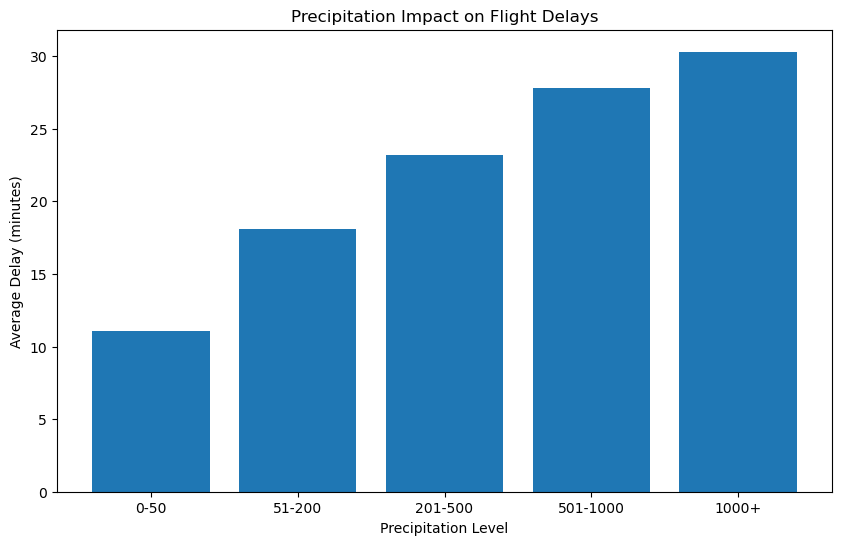

In [16]:
precip_pandas = precipitation_analysis.toPandas()
precip_pandas = precip_pandas.sort_values(by = 'avg_delay')
plt.figure(figsize=(10, 6))
plt.bar(precip_pandas["PRCP_range_source"], precip_pandas["avg_delay"])
plt.xlabel("Precipitation Level")
plt.ylabel("Average Delay (minutes)")
plt.title("Precipitation Impact on Flight Delays")
plt.show()

### ***Clearly and intuitively, more rain = more delay***

## **Identifying which airports are most affected by rain**

In [17]:
correlation_df = df.groupBy(["Origin", "OriginCityName"]) \
    .agg(corr("DepDelayMinutes", "PRCP_origin").alias("correlation"))
sorted_correlation_df = correlation_df.orderBy(desc("correlation"))
sorted_correlation_df.show(10, truncate=False)

+------+---------------------+-------------------+
|Origin|OriginCityName       |correlation        |
+------+---------------------+-------------------+
|YNG   |Youngstown/Warren, OH|1.0                |
|BIH   |Bishop, CA           |0.537581018678703  |
|STC   |St. Cloud, MN        |0.2382212124859661 |
|VCT   |Victoria, TX         |0.22604497491298317|
|HYA   |Hyannis, MA          |0.17832116777110998|
|TYR   |Tyler, TX            |0.1575303577925346 |
|DAL   |Dallas, TX           |0.14496585256464728|
|ADK   |Adak Island, AK      |0.14384402887798736|
|ACT   |Waco, TX             |0.1348617802166199 |
|PRC   |Prescott, AZ         |0.1332922065497396 |
+------+---------------------+-------------------+
only showing top 10 rows



*Youngstown/Warren, OH and Bishop, CA seem to have troubles with departures when it rains*

In [18]:
correlation_df_v2 = df.groupBy(["Dest", "DestCityName"]) \
    .agg(corr("ArrDelayMinutes", "PRCP_dest").alias("correlation"))
sorted_correlation_df = correlation_df_v2.orderBy(desc("correlation"))
sorted_correlation_df.show(10, truncate=False)

+----+---------------------+-------------------+
|Dest|DestCityName         |correlation        |
+----+---------------------+-------------------+
|YNG |Youngstown/Warren, OH|1.0                |
|HYA |Hyannis, MA          |0.19686126195824705|
|DBQ |Dubuque, IA          |0.19468966771124352|
|TYR |Tyler, TX            |0.16158298380959615|
|LGA |New York, NY         |0.15238204214671827|
|ACT |Waco, TX             |0.1493398012770483 |
|DLH |Duluth, MN           |0.1399595010923607 |
|TXK |Texarkana, AR        |0.13655853729020725|
|EWR |Newark, NJ           |0.13473500568166705|
|SWO |Stillwater, OK       |0.13342432507362567|
+----+---------------------+-------------------+
only showing top 10 rows



*Similarly, we observe Youngstown/Warren, OH to have troubles receiving aircrafts during precipitation*

In [19]:
df.groupBy(["Origin"]).count().toPandas().sort_values(by = 'count')

,Origin,count
84,YNG,2
172,BIH,39
211,ILG,118
95,TBN,142
41,ROP,151
...,...,...
182,CLT,781753
237,DFW,943048
146,DEN,1012493
265,ATL,1188099


In [20]:
df.groupBy(["Dest"]).count().toPandas().sort_values(by = 'count')

,Dest,count
84,YNG,2
172,BIH,39
211,ILG,118
95,TBN,142
41,ROP,151
...,...,...
185,CLT,781670
238,DFW,942967
146,DEN,1012502
265,ATL,1188118


### *We can conclude that YNG and BIH are showing up as a result of thin data. No further deep dives needed for these airports.*

## **Map View - Delays**

In [21]:
airports_df = df.select('Origin', 'airport_latitude_origin', 'airport_longitude_origin').groupby('Origin', 'airport_latitude_origin', 'airport_longitude_origin').count()
airports_df = airports_df.na.drop()
airports_df.count()

374

## **Map View - Delay Rate(% Flights Delayed) by Airport**

In [22]:
aggregated_data = df.groupBy("Origin").agg(
    count("*").alias("flight_count"),
    avg("DepDel15").alias("avg_delay_rate")
)

aggregated_data = aggregated_data.na.drop()

filtered_data = aggregated_data.filter(col("flight_count") > 1000)

result_df = filtered_data.join(airports_df, on="Origin", how="inner")

plot_data = result_df.toPandas()
plot_data.to_csv('map_data.csv')

import folium
from branca.colormap import LinearColormap

m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

min_rate = plot_data["avg_delay_rate"].min()
max_rate = plot_data["avg_delay_rate"].max()

colormap = LinearColormap(
    colors=["green", "yellow", "red"],
    vmin=min_rate,
    vmax=max_rate,
    caption="Average Delay Rate",  
)

for _, row in plot_data.iterrows():
    delay_rate = row["avg_delay_rate"]
    color = colormap(delay_rate)
    
    folium.CircleMarker(
        location=[row["airport_latitude_origin"], row["airport_longitude_origin"]],
        radius=8, 
        popup=(
            f"<b>Airport:</b> {row['Origin']}<br>"
            f"<b>Avg Delay Rate:</b> {delay_rate:.2f}<br>"
            f"<b>Flight Count:</b> {row['flight_count']}"
        ),
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

colormap.add_to(m)

m.save("airports_delay_map.html")
m


## ***Covid Impact Summary***

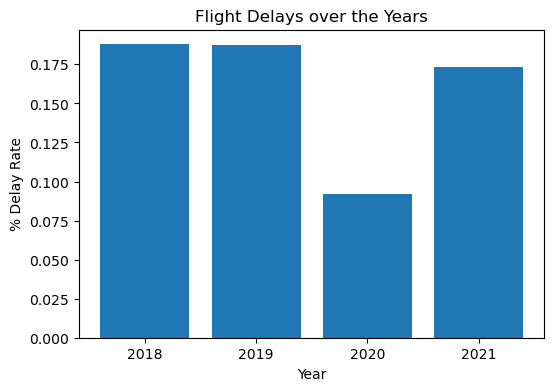

In [23]:
df_covid_pd = df.groupby('Year').agg(avg(col('DepDel15')).alias('Dep Delay Rate')).toPandas()

df_covid_pd = df_covid_pd.sort_values(by = 'Year')
plt.figure(figsize=(6, 4))
plt.bar(df_covid_pd["Year"], df_covid_pd["Dep Delay Rate"])
plt.xticks(df_covid_pd["Year"].astype(int))
plt.xlabel("Year")
plt.ylabel("% Delay Rate")
plt.title("Flight Delays over the Years")
plt.show()

In [24]:
df.groupby('Year').count().show()

+----+-------+
|Year|  count|
+----+-------+
|2018|5689512|
|2019|8091684|
|2020|5022397|
|2021|6311871|
+----+-------+



In [25]:

cutoff_date = "2020-03-01"

one_year_before_cutoff = "2019-03-01"
one_year_after_cutoff = "2021-03-01"

# Filter Pre-COVID data (1 year before the cutoff date)
df_pre_covid  = df.filter(
    (F.col("FlightDate") >= F.lit(one_year_before_cutoff)) &
    (F.col("FlightDate") < F.lit(cutoff_date))
)

# Filter Post-COVID data (1 year after the cutoff date)
df_post_covid  = df.filter(
    (F.col("FlightDate") >= F.lit(cutoff_date)) &
    (F.col("FlightDate") < F.lit(one_year_after_cutoff))
)

print("Pre-COVID Data Count:", df_pre_covid .count())
print("Post-COVID Data Count:", df_post_covid .count())

Pre-COVID Data Count: 8153728


Post-COVID Data Count: 4468292


In [26]:
avg_delay_pre_covid = df_pre_covid.agg(F.avg("DepDelayMinutes").alias("Avg_DepDelay_PreCOVID")).collect()[0]["Avg_DepDelay_PreCOVID"]
avg_delay_post_covid = df_post_covid.agg(F.avg("DepDelayMinutes").alias("Avg_DepDelay_PostCOVID")).collect()[0]["Avg_DepDelay_PostCOVID"]

# Print results
print(f"Average Delay Pre-COVID: {avg_delay_pre_covid}")
print(f"Average Delay Post-COVID: {avg_delay_post_covid}")

Average Delay Pre-COVID: 13.61216944476136
Average Delay Post-COVID: 5.769945719047677


In [27]:
# Calculate the average delay for each airline pre- and post-COVID
avg_delay_per_airline_pre = df_pre_covid.groupBy("Airline").agg(F.avg("DepDelayMinutes").alias("Avg_DepDelay"))
avg_delay_per_airline_post = df_post_covid.groupBy("Airline").agg(F.avg("DepDelayMinutes").alias("Avg_DepDelay"))

# Show results for comparison
print(avg_delay_per_airline_pre.toPandas().sort_values(by=['Avg_DepDelay'],ascending=False).head())
print(avg_delay_per_airline_post.toPandas().sort_values(by=['Avg_DepDelay'],ascending=False).head())

                                      Airline  Avg_DepDelay
15  Commutair Aka Champlain Enterprises, Inc.         28.93
9                      Peninsula Airways Inc.         27.97
7                       Trans States Airlines         22.19
0    GoJet Airlines, LLC d/b/a United Express         19.94
14                            JetBlue Airways         19.81


                                      Airline  Avg_DepDelay
2                               Allegiant Air         12.28
7                       Trans States Airlines         10.56
14  Commutair Aka Champlain Enterprises, Inc.          9.18
21                         Mesa Airlines Inc.          8.78
13                            JetBlue Airways          7.89


- *While Avg. departure delays vary considerably pre and post covid, we see **Commutair, Trans States Airlines and JetBlue Airways** are among the top delayed airlines across the time-periods*

## ***Flight delays were the lowest during the COVID-19 pandemic potentially due to the following reasons:***

- **Reduction in Air Traffic**

    **Significant Drop in Flights:** The pandemic led to a dramatic decline in both domestic and international flights as travel restrictions were imposed worldwide. Fewer flights meant reduced congestion at airports and in airspace

    **Streamlined Operations:** With fewer planes in the sky, air traffic control and ground operations could manage schedules more efficiently, reducing delays.
- **Decrease in Passenger Numbers**

    **Lower Passenger Volumes:** Airlines operated with drastically reduced passenger loads, leading to quicker boarding and deboarding processes

    **Simplified Logistics:**
Fewer passengers meant reduced baggage handling delays and shorter security and check-in lines.
- **Operational Adjustments**

    **Flexible Scheduling:** Airlines adjusted their schedules to match reduced demand, often consolidating flights and removing problematic routes from their timetables

    **More Buffer Time:** Airlines could afford to build more buffer time into their schedules, ensuring timely departures and arrivals

- **Weather Impact Mitigation**

    **Better Weather Management:** With fewer flights, airlines and air traffic control had more flexibility to adjust routes and schedules to avoid severe weather, reducing weather-related delays

- **Air Traffic Control Efficiency**

    **Reduced Airspace Congestion:** With fewer aircraft in the air, delays caused by airspace congestion were minimal.
Optimized Routing: Airlines could take more direct flight paths, reducing flying time and potential delays.

- **Economic and Operational Pressures**

    **On-Time Performance Prioritized:** Airlines faced severe financial pressures and a need to maintain customer satisfaction, leading to a greater focus on punctuality

    **Fewer Complications:** Reduced operations meant less strain on ground staff, aircraft maintenance schedules, and other logistical challenges.

### ***Time-based EDAs***

In [28]:

from pyspark.sql import functions as F

df = df.withColumn('DepHour', (F.floor(F.col('CRSDepTime') / 100)).cast('int'))  # Extract the hour
df = df.withColumn('DepMinute', (F.col('CRSDepTime') % 100).cast('int'))  # Extract the minute

df = df.withColumn('CRSDepTimeStr', 
                   (F.concat(F.col('DepHour').cast('string'),  
                             F.lit(':'),  # Add colon separator
                             F.when(F.col('DepMinute') < 10, F.concat(F.lit('0'), F.col('DepMinute')))  # Leading zero for minutes < 10
                              .otherwise(F.col('DepMinute').cast('string'))
                    )
                   ).alias('CRSDepTimeStr'))
df.select('CRSDepTime', 'DepHour', 'DepMinute', 'CRSDepTimeStr').show(5)


+----------+-------+---------+-------------+
|CRSDepTime|DepHour|DepMinute|CRSDepTimeStr|
+----------+-------+---------+-------------+
|      1515|     15|       15|        15:15|
|      2130|     21|       30|        21:30|
|      1345|     13|       45|        13:45|
|      1907|     19|        7|        19:07|
|      1525|     15|       25|        15:25|
+----------+-------+---------+-------------+
only showing top 5 rows



In [29]:
df = df.withColumn('DepHour', (F.floor(F.col('DepTime') / 100)).cast('int'))  # Extract the hour
df = df.withColumn('DepMinute', (F.col('DepTime') % 100).cast('int'))  # Extract the minute

df = df.withColumn('DepTimeStr', 
                   (F.concat(F.col('DepHour').cast('string'),  
                             F.lit(':'),  # Add colon separator
                             F.when(F.col('DepMinute') < 10, F.concat(F.lit('0'), F.col('DepMinute')))  # Leading zero for minutes < 10
                              .otherwise(F.col('DepMinute').cast('string'))
                    )
                   ).alias('DepTimeStr'))

df.select('CRSDepTime', 'DepHour', 'DepMinute', 'DepTimeStr').show(5)

+----------+-------+---------+----------+
|CRSDepTime|DepHour|DepMinute|DepTimeStr|
+----------+-------+---------+----------+
|      1515|     15|       27|     15:27|
|      2130|     21|       27|     21:27|
|      1345|     13|       43|     13:43|
|      1907|   null|     null|      null|
|      1525|     15|       24|     15:24|
+----------+-------+---------+----------+
only showing top 5 rows



In [30]:
df = df.withColumn('ArrHour', (F.floor(F.col('ArrTime') / 100)).cast('int'))  # Extract the hour
df = df.withColumn('ArrMinute', (F.col('ArrTime') % 100).cast('int'))  # Extract the minute

df = df.withColumn('ArrTimeStr', 
                   (F.concat(F.col('ArrHour').cast('string'),  
                             F.lit(':'),  # Add colon separator
                             F.when(F.col('ArrMinute') < 10, F.concat(F.lit('0'), F.col('ArrMinute')))  # Leading zero for minutes < 10
                              .otherwise(F.col('ArrMinute').cast('string'))  
                    )
                   ).alias('ArrTimeStr'))
df.select('ArrTime', 'ArrHour', 'ArrMinute', 'ArrTimeStr').show(5)

+-------+-------+---------+----------+
|ArrTime|ArrHour|ArrMinute|ArrTimeStr|
+-------+-------+---------+----------+
| 1720.0|     17|       20|     17:20|
| 2321.0|     23|       21|     23:21|
| 1657.0|     16|       57|     16:57|
|   null|   null|     null|      null|
| 1643.0|     16|       43|     16:43|
+-------+-------+---------+----------+
only showing top 5 rows



In [31]:
df = df.withColumn('DepTimeTimestamp',
                   F.to_timestamp(F.concat(F.lit('1970-01-01 '), F.col('DepTimeStr')), 'yyyy-MM-dd HH:mm'))

df = df.withColumn('ArrTimeTimestamp',
                   F.to_timestamp(F.concat(F.lit('1970-01-01 '), F.col('ArrTimeStr')), 'yyyy-MM-dd HH:mm'))

df = df.withColumn('CRSDepTimeTimestamp',
                   F.to_timestamp(F.concat(F.lit('1970-01-01 '), F.col('DepTimeStr')), 'yyyy-MM-dd HH:mm'))


df.select('DepTimeStr', 'DepTimeTimestamp', 'ArrTimeStr', 'ArrTimeTimestamp', 'CRSDepTimeStr', 'CRSDepTimeTimestamp').show(5)


+----------+-------------------+----------+-------------------+-------------+-------------------+
|DepTimeStr|   DepTimeTimestamp|ArrTimeStr|   ArrTimeTimestamp|CRSDepTimeStr|CRSDepTimeTimestamp|
+----------+-------------------+----------+-------------------+-------------+-------------------+
|     15:27|1970-01-01 15:27:00|     17:20|1970-01-01 17:20:00|        15:15|1970-01-01 15:27:00|
|     21:27|1970-01-01 21:27:00|     23:21|1970-01-01 23:21:00|        21:30|1970-01-01 21:27:00|
|     13:43|1970-01-01 13:43:00|     16:57|1970-01-01 16:57:00|        13:45|1970-01-01 13:43:00|
|      null|               null|      null|               null|        19:07|               null|
|     15:24|1970-01-01 15:24:00|     16:43|1970-01-01 16:43:00|        15:25|1970-01-01 15:24:00|
+----------+-------------------+----------+-------------------+-------------+-------------------+
only showing top 5 rows



### ***Delay by time blocks***

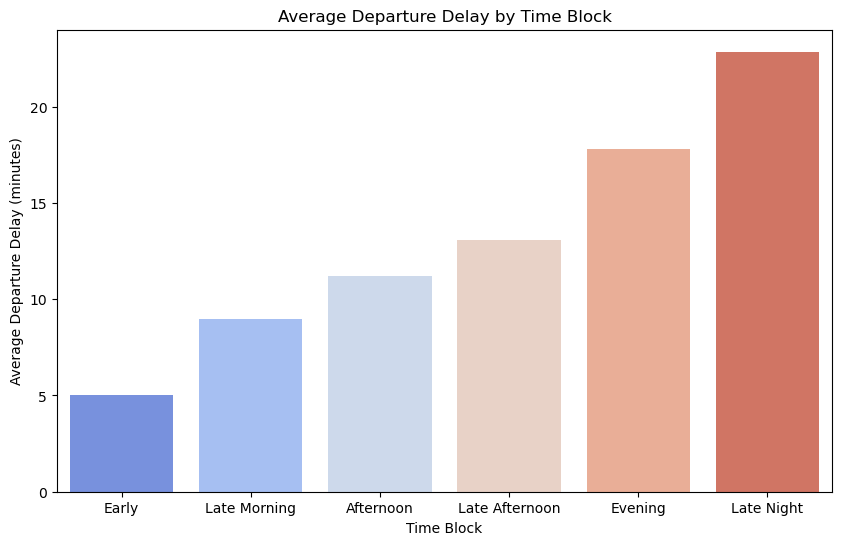

In [32]:
df = df.withColumn('DepHour', hour('DepTimeTimeStamp'))

df = df.withColumn('TimeBlock', 
                   when((col('DepHour') >= 6) & (col('DepHour') < 9), 'Early')
                   .when((col('DepHour') >= 9) & (col('DepHour') < 12), 'Late Morning')
                   .when((col('DepHour') >= 12) & (col('DepHour') < 15), 'Afternoon')
                   .when((col('DepHour') >= 15) & (col('DepHour') < 18), 'Late Afternoon')
                   .when((col('DepHour') >= 18) & (col('DepHour') < 21), 'Evening')
                   .otherwise('Late Night'))

delay_by_timeblock = df.groupBy('TimeBlock').agg(
    avg('DepDelayMinutes').alias('AvgDepDelay')
).orderBy('AvgDepDelay')

delay_by_timeblock_pd = delay_by_timeblock.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='TimeBlock', y='AvgDepDelay', data=delay_by_timeblock_pd, palette='coolwarm')
plt.title('Average Departure Delay by Time Block')
plt.xlabel('Time Block')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()

***We see that as the day progresses, avg. departure delay is higher with avg. delay during late night more than ~4x compared to early mornings.***

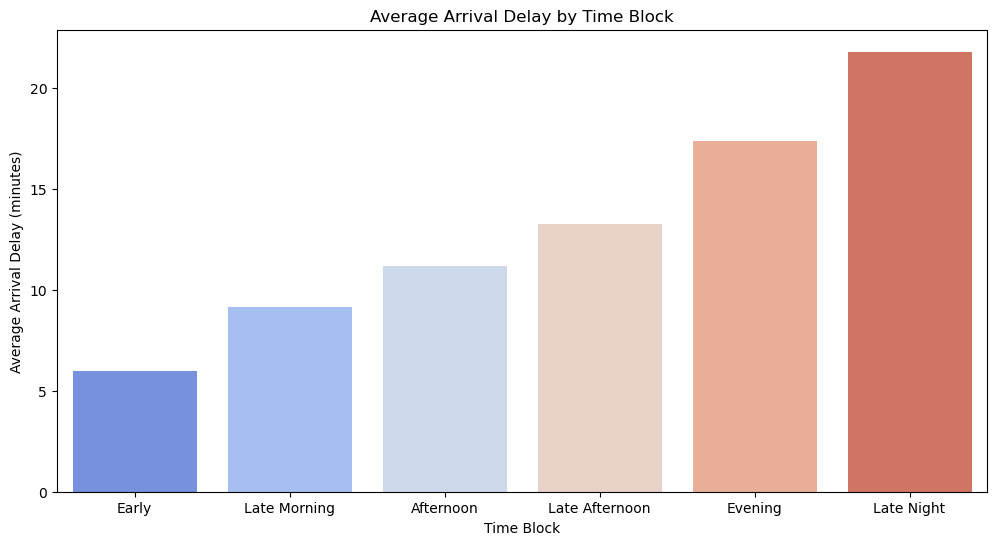

In [33]:
delay_by_timeblock_pd = df.groupBy('TimeBlock').agg(
    avg('ArrDelayMinutes').alias('AvgArrDelay')
).orderBy('AvgArrDelay').toPandas()

plt.figure(figsize=(12, 6))

sns.barplot(x='TimeBlock', y='AvgArrDelay', data=delay_by_timeblock_pd, palette='coolwarm')
plt.title('Average Arrival Delay by Time Block')
plt.xlabel('Time Block')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()

***Similar trends are observed for arrival delays***

### ***Quarter wise avg. delay by hour of the day - Arrival and Departure***

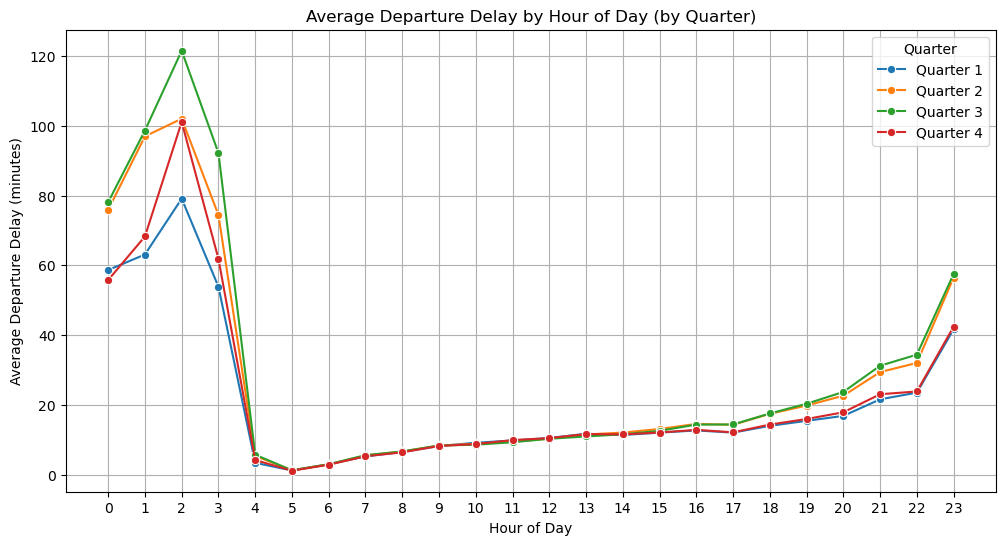

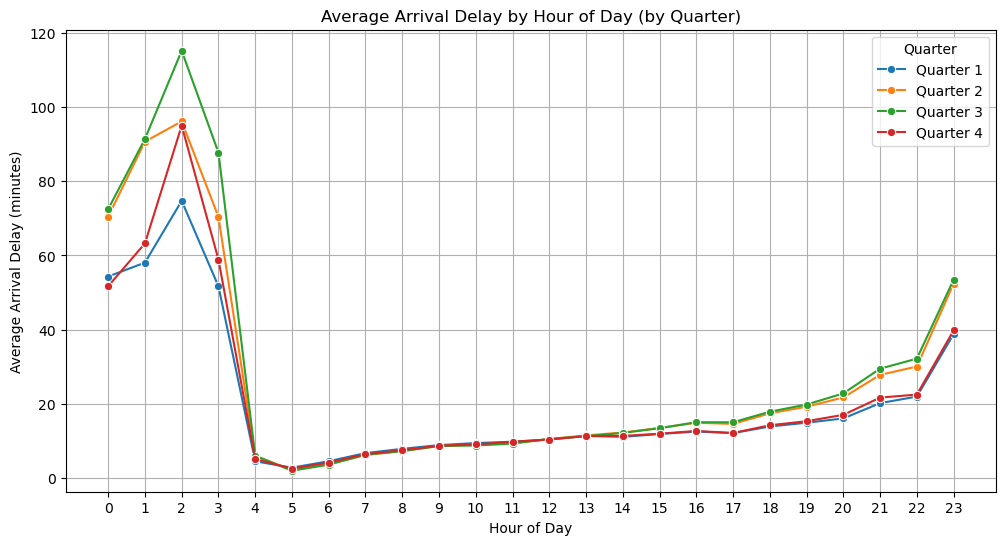

In [34]:
df = df.withColumn("Quarter", 
                   when(df["Month"].isin([1, 2, 3]), 1)
                   .when(df["Month"].isin([4, 5, 6]), 2)
                   .when(df["Month"].isin([7, 8, 9]), 3)
                   .otherwise(4))
delay_by_hour_quarter = df.groupBy('DepHour', 'Quarter').agg(
    F.avg('DepDelayMinutes').alias('AvgDepDelay'),
    F.avg('ArrDelayMinutes').alias('AvgArrDelay'),
    F.count('DepDelayMinutes').alias('flight_count')
).orderBy('DepHour', 'Quarter')

delay_by_hour_quarter_pd = delay_by_hour_quarter.toPandas()

plt.figure(figsize=(12, 6))

for quarter in delay_by_hour_quarter_pd['Quarter'].unique():
    quarter_data = delay_by_hour_quarter_pd[delay_by_hour_quarter_pd['Quarter'] == quarter]
    sns.lineplot(x='DepHour', y='AvgDepDelay', data=quarter_data, label=f'Quarter {quarter}', marker='o')

plt.title('Average Departure Delay by Hour of Day (by Quarter)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(range(0, 24))  
plt.legend(title='Quarter')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for quarter in delay_by_hour_quarter_pd['Quarter'].unique():
    quarter_data = delay_by_hour_quarter_pd[delay_by_hour_quarter_pd['Quarter'] == quarter]
    sns.lineplot(x='DepHour', y='AvgArrDelay', data=quarter_data, label=f'Quarter {quarter}', marker='o')

plt.title('Average Arrival Delay by Hour of Day (by Quarter)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xticks(range(0, 24))
plt.legend(title='Quarter')
plt.grid(True)
plt.show()

- ***Avg. Delay is higher in Q2 and Q3 during day end and start***
- ***The spike at 1 AM and 2 AM could potentially be due to thin data***
    - ***Nevertheless, it's very likely that late night flights experience delays***

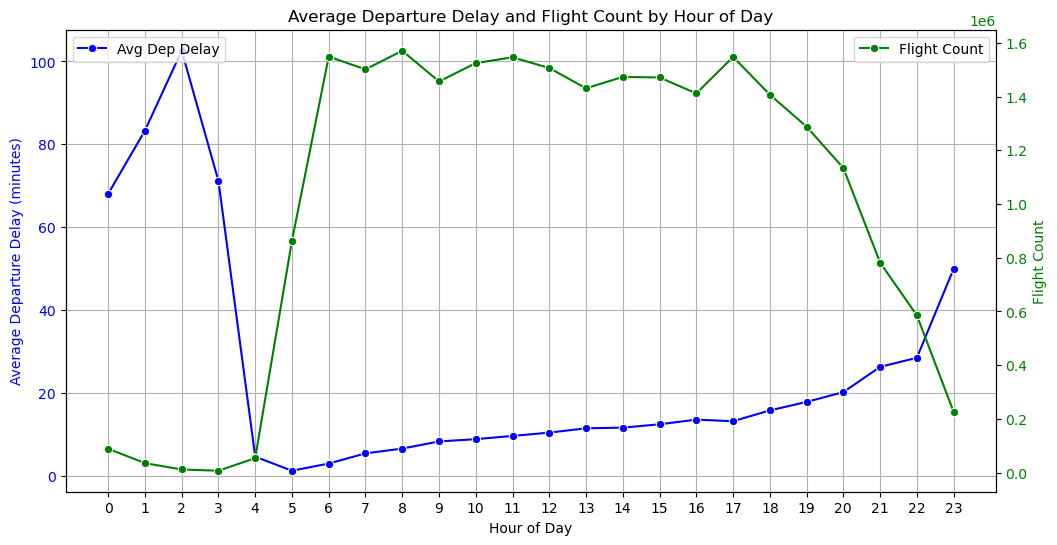

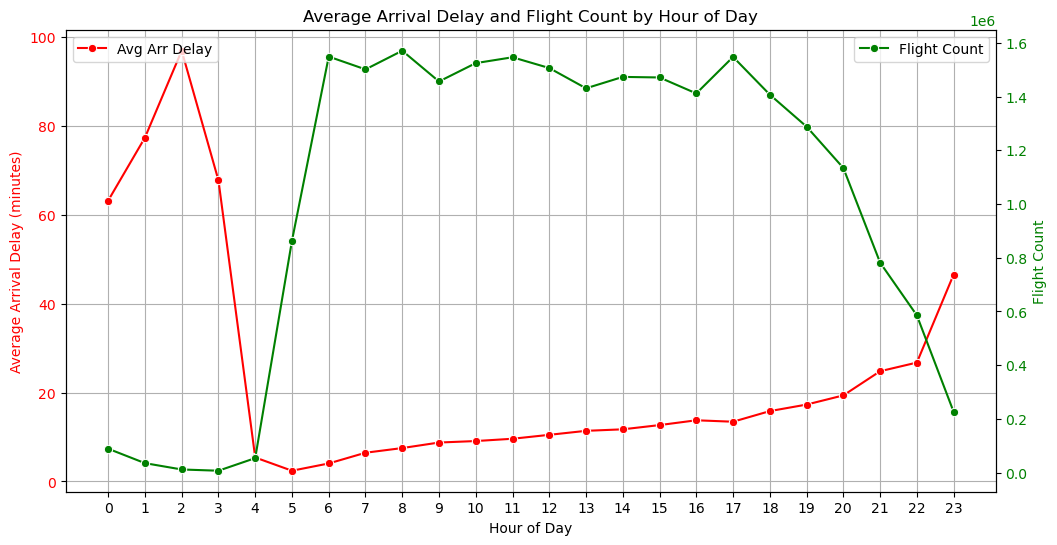

In [35]:
from pyspark.sql.functions import count

delay_by_hour = df.groupBy('DepHour').agg(
    avg('DepDelayMinutes').alias('AvgDepDelay'),
    avg('ArrDelayMinutes').alias('AvgArrDelay'),
    count('DepDelayMinutes').alias('FlightCount')
).orderBy('DepHour')

delay_by_hour_pd = delay_by_hour.toPandas()


import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(x='DepHour', y='AvgDepDelay', data=delay_by_hour_pd, marker='o', color='blue', label='Avg Dep Delay', ax=ax1)
ax1.set_title('Average Departure Delay and Flight Count by Hour of Day')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Departure Delay (minutes)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0, 24))
ax1.grid(True)

ax2 = ax1.twinx()
sns.lineplot(x='DepHour', y='FlightCount', data=delay_by_hour_pd, marker='o', color='green', label='Flight Count', ax=ax2)
ax2.set_ylabel('Flight Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(x='DepHour', y='AvgArrDelay', data=delay_by_hour_pd, marker='o', color='red', label='Avg Arr Delay', ax=ax1)
ax1.set_title('Average Arrival Delay and Flight Count by Hour of Day')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Arrival Delay (minutes)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(range(0, 24))
ax1.grid(True)

ax2 = ax1.twinx()
sns.lineplot(x='DepHour', y='FlightCount', data=delay_by_hour_pd, marker='o', color='green', label='Flight Count', ax=ax2)
ax2.set_ylabel('Flight Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Show both legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


- ***Number of journeys between 11PM - 4AM is minimal and these flights contribute most to avg. delay in departure and arrival***

### ***Analyzing the relation between flight delay and journey distance***

In [36]:
df.describe('Distance', 'DepDelayMinutes', 'ArrDelayMinutes').show()

df_grouped = df.groupBy('DistanceGroup').agg(
    F.mean('DepDelayMinutes').alias('AvgDepDelay'),
    F.mean('ArrDelayMinutes').alias('AvgArrDelay'),
    F.stddev('DepDelayMinutes').alias('StdDevDepDelay'),
    F.stddev('ArrDelayMinutes').alias('StdDevArrDelay'),
    F.min('DepDelayMinutes').alias('MinDepDelay'),
    F.min('ArrDelayMinutes').alias('MinArrDelay'),
    F.max('DepDelayMinutes').alias('MaxDepDelay'),
    F.max('ArrDelayMinutes').alias('MaxArrDelay')
)

df_grouped.show()

+-------+-----------------+------------------+-----------------+
|summary|         Distance|   DepDelayMinutes|  ArrDelayMinutes|
+-------+-----------------+------------------+-----------------+
|  count|         25115464|          24472875|         24402683|
|   mean|776.7903814558234|12.260446473902228|12.32927953045163|
| stddev|579.5470730771842| 45.07987594753483|44.70098505593977|
|    min|             16.0|               0.0|              0.0|
|    max|           5812.0|            3890.0|           3864.0|
+-------+-----------------+------------------+-----------------+



+-------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+
|DistanceGroup|       AvgDepDelay|       AvgArrDelay|    StdDevDepDelay|    StdDevArrDelay|MinDepDelay|MinArrDelay|MaxDepDelay|MaxArrDelay|
+-------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+
|            1|11.502493108392816|11.921860236220473| 45.31204555701818| 45.09143133900417|        0.0|        0.0|     2688.0|     2671.0|
|            6|12.012342663653342|11.835262565608174| 43.58466340936925| 42.85307909760714|        0.0|        0.0|     2326.0|     2367.0|
|            3|12.347791384762177|12.515416644247525|46.098606064159185| 45.84227146839508|        0.0|        0.0|     2941.0|     2923.0|
|            5| 13.59633804840087|13.573435373489701|  46.7659157587955|46.250170220715034|        0.0|        0.0|     3095.0|     3089.0|
|            9|12.46

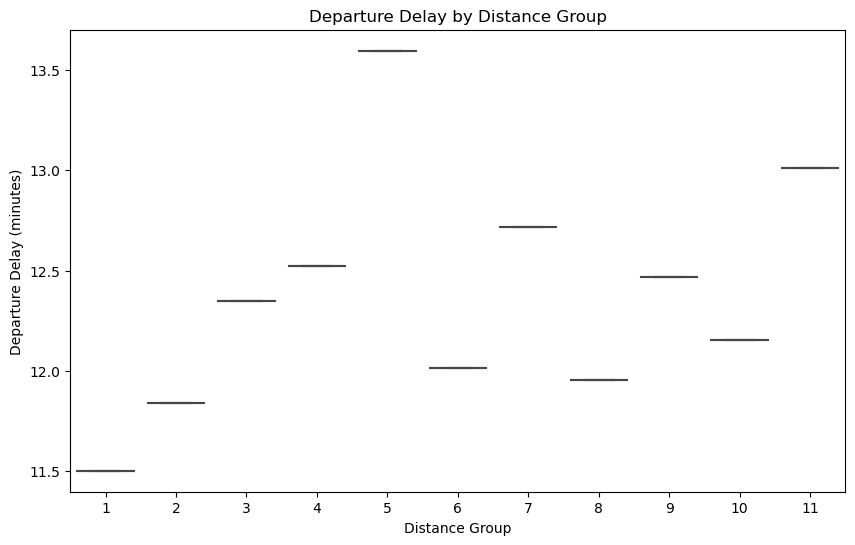

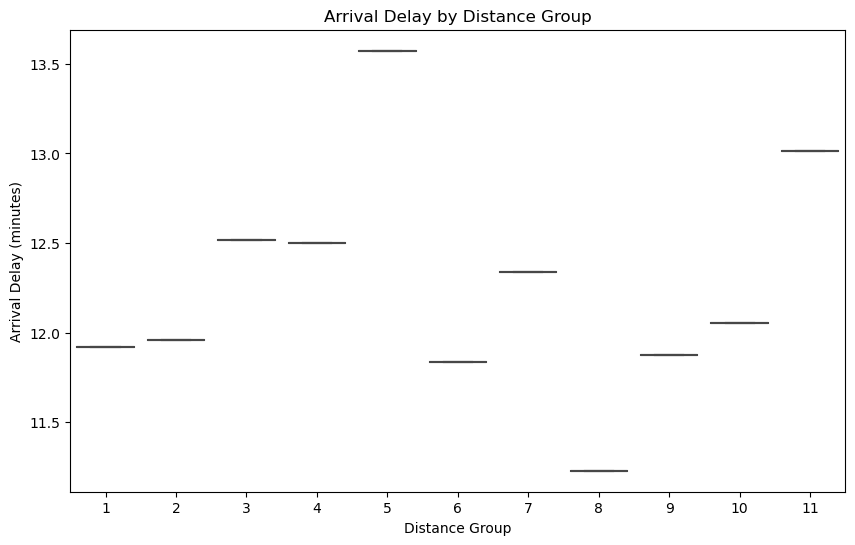

In [37]:
plot_df=df_grouped.select('DistanceGroup','AvgDepDelay','AvgArrDelay').toPandas()
plt.figure(figsize=(10, 6))
sns.boxplot(x='DistanceGroup', y='AvgDepDelay', data=plot_df)
plt.title('Departure Delay by Distance Group')
plt.xlabel('Distance Group')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='DistanceGroup', y='AvgArrDelay', data=plot_df)
plt.title('Arrival Delay by Distance Group')
plt.xlabel('Distance Group')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

- ***The above two curves replicate a log curve. As the distance of journey is caategorized as distance group "5", avg. delay and distance is strongly correlated.*** 
- ***However, after a certain distance, the avg. delays do not increase and remain almost similar***

## **States - Highest pair-wise delays**

In [39]:
state_delays = df.groupBy("OriginState", "DestState").agg(
    avg("DepDelayMinutes").alias("Avg_Departure_Delay"),
    avg("ArrDelayMinutes").alias("Avg_Arrival_Delay")
)

city_delays = df.groupBy("OriginCityName", "DestCityName").agg(
    avg("DepDelayMinutes").alias("Avg_Departure_Delay"),
    avg("ArrDelayMinutes").alias("Avg_Arrival_Delay")
)

In [40]:
state_delays.select("OriginState","DestState","Avg_Departure_Delay").orderBy(col("Avg_Departure_Delay").desc()).show()

+-----------+---------+-------------------+
|OriginState|DestState|Avg_Departure_Delay|
+-----------+---------+-------------------+
|         IA|       IA|              295.0|
|         KS|       OH|              181.0|
|         KS|       WI|              106.0|
|         WY|       SD|              104.0|
|         AL|       CA|  95.33333333333333|
|         LA|       SC|  85.33333333333333|
|         MT|       WY|               81.5|
|         MT|       ID|               65.0|
|         AK|       NY|           61.34375|
|         ID|       TN|  56.17857142857143|
|         MT|       PA|  54.08247422680412|
|         OK|       OK|               53.0|
|         ME|       IN| 47.981818181818184|
|         NY|       ID| 47.421052631578945|
|         SD|       PA| 45.666666666666664|
|         PA|       SD|               44.0|
|         WY|       NJ|   42.0672268907563|
|         PR|       KY|              41.95|
|         LA|       OK|               40.0|
|         ND|       GA|  39.4339

***Flights that travel within IA have the highest avg. departure delays in the country***

In [41]:
state_delays.select("OriginState","DestState","Avg_Arrival_Delay").orderBy(col("Avg_Arrival_Delay").desc()).show()

+-----------+---------+------------------+
|OriginState|DestState| Avg_Arrival_Delay|
+-----------+---------+------------------+
|         KS|       OH|             210.0|
|         AL|       CA|108.66666666666667|
|         LA|       SC|              80.0|
|         OK|       OK|              69.0|
|         ID|       TN| 62.67857142857143|
|         MT|       ID|              61.0|
|         MT|       PA|54.885416666666664|
|         AK|       NY|              54.0|
|         NH|       TN| 46.47826086956522|
|         PR|       KY|              45.0|
|         SD|       TN|44.390243902439025|
|         ME|       IN| 44.07272727272727|
|         PA|       SD|43.666666666666664|
|         ND|       GA| 42.19607843137255|
|         WY|       NJ| 41.51267605633803|
|         AR|       NJ| 41.26502732240437|
|         MT|       NJ| 40.65964912280702|
|         SC|       LA|39.666666666666664|
|         MT|       NY|            38.585|
|         SC|       NV| 38.27777777777778|
+----------

***Flights that travel between KS and OH have the highest avg. arrival delays***

## **Cities - Highest pair-wise delays**

In [42]:
city_delays.select("OriginCityName","DestCityName","Avg_Departure_Delay").orderBy(col("Avg_Departure_Delay").desc()).show()

+--------------------+--------------------+-------------------+
|      OriginCityName|        DestCityName|Avg_Departure_Delay|
+--------------------+--------------------+-------------------+
|         Wichita, KS|Manhattan/Ft. Ril...|             1484.0|
|    Bend/Redmond, OR|         Medford, OR|              814.0|
|      Harrisburg, PA|    White Plains, NY|              759.0|
|      Valparaiso, FL|Sarasota/Bradento...|              720.0|
|           Fargo, ND|       Jamestown, ND|              411.5|
|       Rochester, MN|           Fargo, ND|              399.0|
|Mission/McAllen/E...|     Brownsville, TX|              394.0|
|   Oklahoma City, OK|           Aspen, CO|              386.0|
|      Des Moines, IA|Cedar Rapids/Iowa...|              295.0|
|       Milwaukee, WI|       Marquette, MI|              266.0|
|   State College, PA|Cedar Rapids/Iowa...|              246.0|
|          Tucson, AZ|         Detroit, MI|              227.0|
|         Spokane, WA|        Lewiston, 

***Wichita -> Manhattan, Bend -> Medford, Harrisburg -> White Plains and Valaparaiso -> Sarasota have the highest avg. departure delays***

In [54]:
city_delays.select("OriginCityName","DestCityName","Avg_Arrival_Delay").orderBy(col("Avg_Arrival_Delay").desc()).show()

+--------------------+--------------------+------------------+
|      OriginCityName|        DestCityName| Avg_Arrival_Delay|
+--------------------+--------------------+------------------+
|    Bend/Redmond, OR|         Medford, OR|            1347.0|
|      Harrisburg, PA|    White Plains, NY|             798.0|
|      Valparaiso, FL|Sarasota/Bradento...|             744.0|
|         Wichita, KS|          Dayton, OH|             210.0|
|     Chattanooga, TN|     Minneapolis, MN|             206.0|
|   State College, PA|Cedar Rapids/Iowa...|             195.0|
|       Santa Ana, CA|           Aspen, CO|170.84615384615384|
|      Des Moines, IA|          Peoria, IL|             168.0|
|            Erie, PA| Ithaca/Cortland, NY|             160.0|
|           Flint, MI|         Phoenix, AZ|152.76923076923077|
|      Birmingham, AL|   San Francisco, CA|             148.0|
|Youngstown/Warren...|  St. Petersburg, FL|             141.0|
|Newburgh/Poughkee...|West Palm Beach/P...|            

***Considering the top 3 pairs overlap, we can infer they occur due to thin data as delays in departure contributte to delays in arrivals***

### **Distribution of Delays**

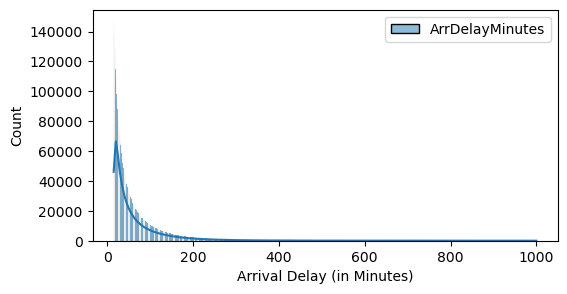

In [44]:
df_arr_delay = df.filter(F.col('ArrDel15') == 1).select('ArrDelayMinutes')
df_arr_delay_pd = df_arr_delay.toPandas()

plt.figure(figsize=(6,3))
sns.histplot(df_arr_delay_pd[df_arr_delay_pd['ArrDelayMinutes'] <=1000], kde = True)
plt.xlabel('Arrival Delay (in Minutes)')
plt.show()

### ***Annual, monthly trend of delays***

Text(0.5, 1.0, 'Flight Delay by Date')

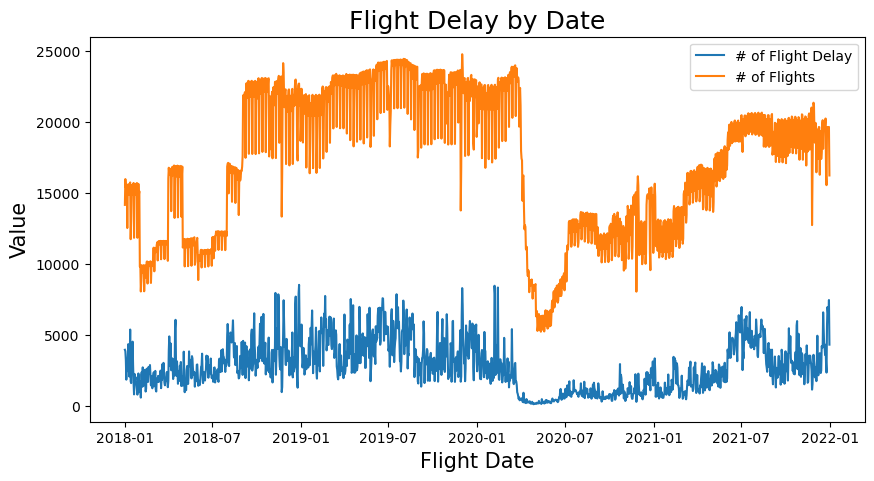

In [45]:
daily_delay_df = df.filter(col('ArrDel15') == 1).groupby('FlightDate').count().withColumnRenamed('count','num_flight_delay')
daily_all_df = df.groupby('FlightDate').count().withColumnRenamed('count','num_flights')
daily_df = daily_all_df.join(daily_delay_df, on ='FlightDate', how = 'left')

daily_df_pd = daily_df.toPandas()
plt.figure(figsize=(10,5))
sns.lineplot(data = daily_df_pd, x = 'FlightDate', y = 'num_flight_delay', label = '# of Flight Delay')
sns.lineplot(data = daily_df_pd, x = 'FlightDate', y = 'num_flights', label = '# of Flights')
plt.xlabel('Flight Date', fontsize = 15)
plt.ylabel('Value', fontsize = 15)
plt.title("Flight Delay by Date", fontsize = 18)

***We observe a dip in total # Flights and # Delayed Flights in the beginning of 2020 as expected***

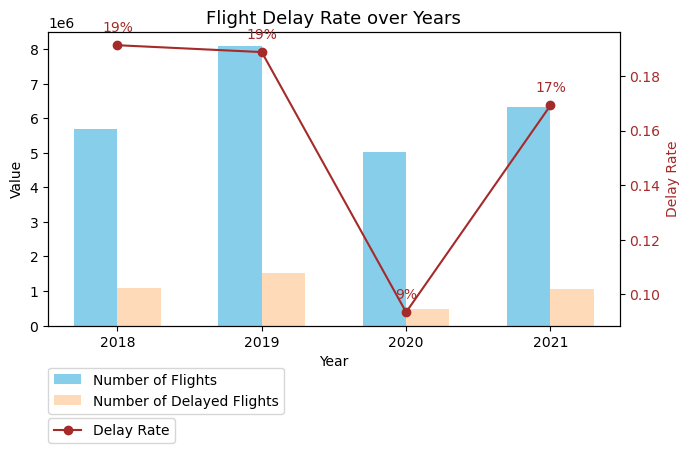

In [46]:
import numpy as np
yearly_delay_df = df.filter(col('ArrDel15') == 1).groupby('Year').count().withColumnRenamed('count','num_flight_delay')
yearly_all_df = df.groupby('Year').count().withColumnRenamed('count','num_flight')
yearly_df = yearly_all_df.join(yearly_delay_df, on =['Year'], how = 'left')
yearly_df = yearly_df.withColumn('delay_rate', col('num_flight_delay') / col('num_flight'))

yearly_df_pd = yearly_df.toPandas()

fig, ax1 = plt.subplots(figsize=(7, 5))

x = np.arange(len(yearly_df_pd['Year']))  # Label locations
width = 0.30  # Width of the bars

# Bar charts for user_num and default_num
bars1 = ax1.bar(x - width/2, yearly_df_pd['num_flight'], width, label='Number of Flights', color='skyblue')
bars2 = ax1.bar(x + width/2, yearly_df_pd['num_flight_delay'], width, label='Number of Delayed Flights', color='peachpuff')

ax1.set_xlabel("Year")
ax1.set_ylabel("Value")
ax1.set_xticks(x)
ax1.set_xticklabels(yearly_df_pd['Year'])
ax1.legend(loc="lower left", bbox_to_anchor=(0, -0.3), borderaxespad=0)

ax2 = ax1.twinx()
ax2.plot(x, yearly_df_pd['delay_rate'], color='brown', marker='o', label='Delay Rate')
ax2.set_ylabel("Delay Rate", color='brown')
ax2.tick_params(axis='y', labelcolor='brown')
ax2.legend(loc="lower left", bbox_to_anchor=(0, -0.4), borderaxespad=0)


for i, rate in enumerate(yearly_df_pd['delay_rate']):
    ax2.annotate(f"{rate:.0%}", (x[i], rate), textcoords="offset points", xytext=(0, 10), ha='center', color='brown')

plt.title("Flight Delay Rate over Years", fontsize = 13)

fig.tight_layout()
plt.show()

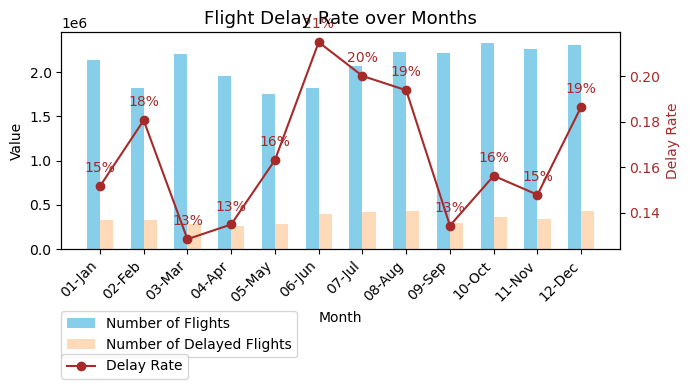

In [47]:
monthly_delay_df = df.filter(col('ArrDel15') == 1).groupby('Month').count().withColumnRenamed('count','num_flight_delay')
monthly_all_df = df.groupby('Month').count().withColumnRenamed('count','num_flight')
monthly_df = monthly_all_df.join(monthly_delay_df, on ='Month', how = 'left')
monthly_df = monthly_df.withColumn('delay_rate', col('num_flight_delay') / col('num_flight'))

month_map = {1: "01-Jan", 2: "02-Feb", 3: "03-Mar", 4: "04-Apr", 5: "05-May", 6: "06-Jun",
             7: "07-Jul", 8: "08-Aug", 9: "09-Sep", 10: "10-Oct", 11: "11-Nov", 12: "12-Dec"}

case_expr = "CASE " + " ".join([f"WHEN month = {k} THEN '{v}'" for k, v in month_map.items()]) + " END"
monthly_df = monthly_df.withColumn("month_name", expr(case_expr))
monthly_df = monthly_df.orderBy('month_name')

monthly_df_pd = monthly_df.toPandas()

fig, ax1 = plt.subplots(figsize=(7, 5))

x = np.arange(len(monthly_df_pd['month_name']))  
width = 0.30 

bars1 = ax1.bar(x - width/2, monthly_df_pd['num_flight'], width, label='Number of Flights', color='skyblue')
bars2 = ax1.bar(x + width/2, monthly_df_pd['num_flight_delay'], width, label='Number of Delayed Flights', color='peachpuff')

ax1.set_xlabel("Month")
ax1.set_ylabel("Value")
ax1.set_xticks(x)
ax1.set_xticklabels(monthly_df_pd['month_name'], rotation=45, ha='right')
ax1.legend(loc="lower left", bbox_to_anchor=(0, -0.5), borderaxespad=0)

ax2 = ax1.twinx()
ax2.plot(x, monthly_df_pd['delay_rate'], color='brown', marker='o', label='Delay Rate')
ax2.set_ylabel("Delay Rate", color='brown')
ax2.tick_params(axis='y', labelcolor='brown')
ax2.legend(loc="lower left", bbox_to_anchor=(0, -0.6), borderaxespad=0)


for i, rate in enumerate(monthly_df_pd['delay_rate']):
    ax2.annotate(f"{rate:.0%}", (x[i], rate), textcoords="offset points", xytext=(0, 10), ha='center', color='brown')

plt.title("Flight Delay Rate over Months", fontsize = 13)

fig.tight_layout()
plt.show()


***Feb, Jun, Jul, Aug and Dec have the highest % delayed flights (min delay: 15 mins)***

## **Identifying delay trends by airlines**
- Analyzing % Delayed Flights (Delay Rate) by airline

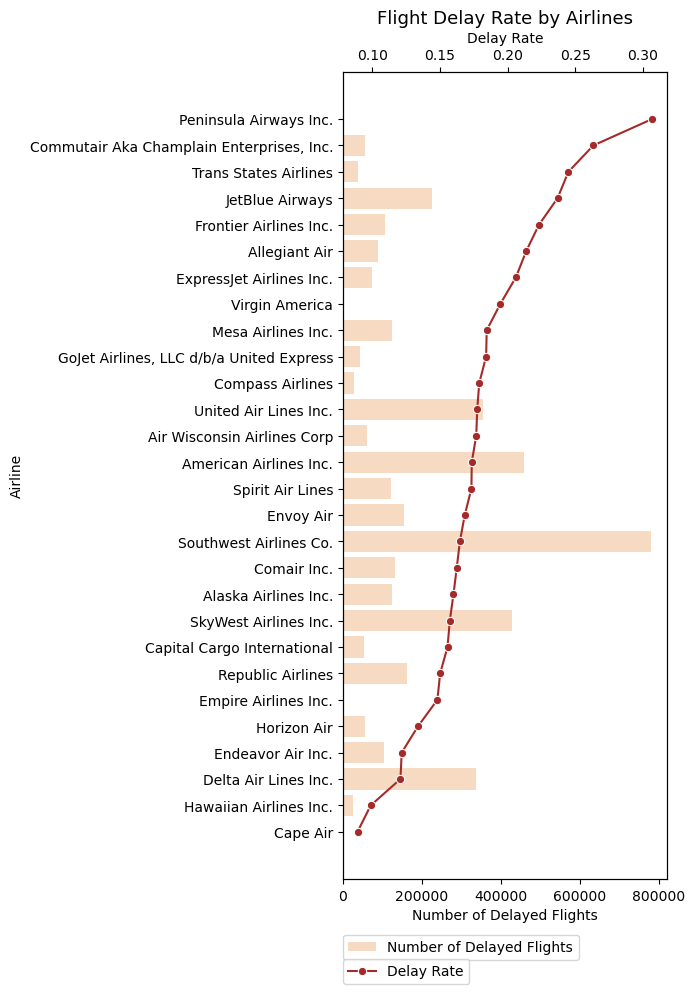

In [49]:
df_delay_airline = df.filter(col('ArrDel15') == 1).groupby('Airline').count().withColumnRenamed('count', 'num_flight_delays')
df_all_airline = df.groupby('Airline').count().withColumnRenamed('count', 'num_flight')
df_airline = df_all_airline.join(df_delay_airline, on='Airline', how='left')
df_airline = df_airline.withColumn('delay_rate', col('num_flight_delays')/col('num_flight'))
df_airline = df_airline.orderBy('delay_rate', ascending = False)
df_airline_pd = df_airline.toPandas()

x = np.arange(len(df_airline_pd['Airline']))  # Label locations

fig, ax1 = plt.subplots(figsize=(7, 10))

bars = sns.barplot(data=df_airline_pd, y='Airline', x='num_flight_delays', orient='h', ax=ax1, color='peachpuff', label='Number of Delayed Flights')

ax1.set_xlabel("Number of Delayed Flights")
ax1.set_ylabel("Airline")
ax1.legend(loc="lower left", bbox_to_anchor=(0, -0.1), borderaxespad=0)

ax2 = ax1.twiny()
sns.lineplot(data=df_airline_pd, x='delay_rate', y='Airline', marker='o', ax=ax2, color='brown', label='Delay Rate')
ax2.set_xlabel("Delay Rate")
ax2.legend(loc="lower left", bbox_to_anchor=(0, -0.13), borderaxespad=0)

for i, rate in enumerate(df_airline_pd['delay_rate']):
    ax2.annotate(f"{rate:.0%}", (x[i], rate), textcoords="offset points", xytext=(0, 10), ha='center', color='brown')
    
plt.title("Flight Delay Rate by Airlines", fontsize = 13)

fig.tight_layout()
plt.show()

***Some top names with high % delayed flights that also have a large fleet of aircrafts include Frontier and JetBlue***

## **Delays by airports**

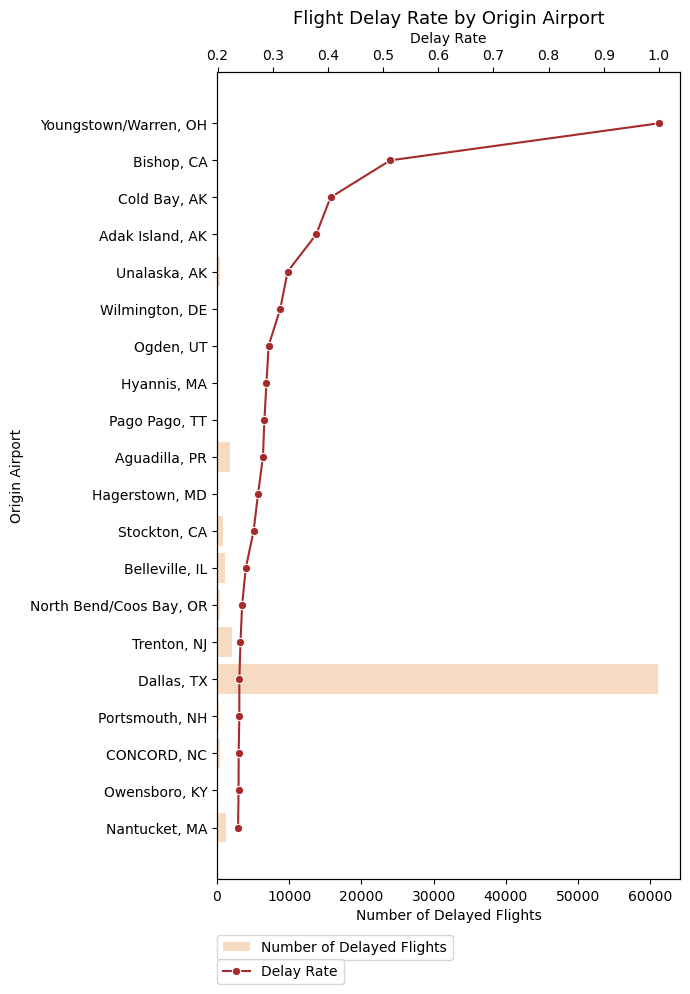

In [50]:
df_delay_airport = df.filter(col('DepDel15') == 1).groupby('OriginCityName').count().withColumnRenamed('count', 'num_flight_delays')
df_all_airport = df.groupby('OriginCityName').count().withColumnRenamed('count', 'num_flight')
df_airport = df_all_airport.join(df_delay_airport, on='OriginCityName', how='left')
df_airport = df_airport.withColumn('delay_rate', col('num_flight_delays')/col('num_flight'))
df_airport = df_airport.orderBy('delay_rate', ascending = False).limit(20)

df_airport_pd = df_airport.toPandas()

x = np.arange(len(df_airport_pd['OriginCityName']))  # Label locations

fig, ax1 = plt.subplots(figsize=(7, 10))

bars = sns.barplot(data=df_airport_pd, y='OriginCityName', x='num_flight_delays', orient='h', ax=ax1, color='peachpuff', label='Number of Delayed Flights')

ax1.set_xlabel("Number of Delayed Flights")
ax1.set_ylabel("Origin Airport")
ax1.legend(loc="lower left", bbox_to_anchor=(0, -0.1), borderaxespad=0)

ax2 = ax1.twiny()
sns.lineplot(data=df_airport_pd, x='delay_rate', y='OriginCityName', marker='o', ax=ax2, color='brown', label='Delay Rate')
ax2.set_xlabel("Delay Rate")
ax2.legend(loc="lower left", bbox_to_anchor=(0, -0.13), borderaxespad=0)


plt.title("Flight Delay Rate by Origin Airport", fontsize = 13)

fig.tight_layout()
plt.show()

***Dallas, TX is one of the major hubs with a high delay rate in departures(~25%)***

### ***Cancellations and Diversions EDAs***

In [51]:
from pyspark.sql.functions import sum as _sum

df = df.withColumn("Cancelled", col("Cancelled").cast("int")) \
           .withColumn("Diverted", col("Diverted").cast("int"))

airline_metrics = df.groupBy("Airline").agg(
    avg("ArrDelayMinutes").alias("Average_Delay"),
    (_sum(col("Cancelled")) / count("*")).alias("Cancellation_Rate"),
    (_sum(col("Diverted")) / count("*")).alias("Diversion_Rate"))

In [52]:
airline_metrics_cancellation = airline_metrics.select("Airline","Cancellation_Rate").orderBy(col("Cancellation_Rate").desc())
airline_metrics_cancellation.show(truncate=False)

+-----------------------------------------+--------------------+
|Airline                                  |Cancellation_Rate   |
+-----------------------------------------+--------------------+
|Peninsula Airways Inc.                   |0.15486884656845132 |
|Empire Airlines Inc.                     |0.05592076809964536 |
|Allegiant Air                            |0.04693000173120203 |
|Commutair Aka Champlain Enterprises, Inc.|0.04398625748211479 |
|Capital Cargo International              |0.0412755318647106  |
|Trans States Airlines                    |0.04093075066526394 |
|ExpressJet Airlines Inc.                 |0.040611419151805786|
|Air Wisconsin Airlines Corp              |0.037263681884778556|
|Envoy Air                                |0.03495802694084727 |
|Mesa Airlines Inc.                       |0.03368505294989693 |
|Southwest Airlines Co.                   |0.032313501098807484|
|Comair Inc.                              |0.032196324037908966|
|American Airlines Inc.  

***Seems like Peninsula Airways Inc. has the highest cancellation rate. We observe a long tail of airlines otherwise  with no notable trends***

In [53]:
airline_metrics_diversion = airline_metrics.select("Airline","Diversion_Rate").orderBy(col("Diversion_Rate").desc())
airline_metrics_diversion.show(truncate=False)

+-----------------------------------------+---------------------+
|Airline                                  |Diversion_Rate       |
+-----------------------------------------+---------------------+
|Peninsula Airways Inc.                   |0.021200143729788    |
|Virgin America                           |0.004753820033955857 |
|Empire Airlines Inc.                     |0.004541129660064008 |
|Trans States Airlines                    |0.0036945355529426327|
|SkyWest Airlines Inc.                    |0.0031590260092773633|
|Commutair Aka Champlain Enterprises, Inc.|0.0031528043731251245|
|JetBlue Airways                          |0.0030433399418088964|
|ExpressJet Airlines Inc.                 |0.0030254277304485266|
|Allegiant Air                            |0.0029983457402812243|
|Capital Cargo International              |0.0028214774281805745|
|United Air Lines Inc.                    |0.0025482777028447527|
|Mesa Airlines Inc.                       |0.0025441347579306718|
|Comair In

***No notable trends in diversions***